In [1]:
!nvidia-smi

Fri Oct 13 12:37:38 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.86.10              Driver Version: 535.86.10    CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-80GB          On  | 00000000:88:00.0 Off |                    0 |
| N/A   24C    P0              65W / 400W |   2909MiB / 81920MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [2]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['BASE_PATH'] = '..'

In [3]:
import hydra
import os
import os.path as osp

import torch
from torch import FloatTensor, Tensor, LongTensor

from omegaconf import DictConfig, OmegaConf
from hydra.utils import instantiate

from typing import Dict, List, Optional, Union, Tuple

from lightning import seed_everything, Trainer
from lightning.pytorch.callbacks import ModelCheckpoint, LearningRateMonitor
from lightning.pytorch.loggers import WandbLogger
from lightning.pytorch.strategies.ddp import DDPStrategy
from glob import glob
from torch_ema import ExponentialMovingAverage

from torch.utils.data import DataLoader

from diffusion import Config
import diffusion
import json

In [4]:
from diffusion.dynamics import SDE, RSDE, EulerSolver
from diffusion.utils import calc_model_grads_norm, calc_model_weights_norm, filter_losses
from diffusion.models.contextual_denoising.modeling_clean_encoder import T5EncoderModel
from diffusion.models.contextual_denoising.modeling_noisy_encoder import BertLMHeadModel
from diffusion.models.contextual_denoising.score_estimator import ScoreEstimator
from diffusion.models.contextual_denoising.typings import EncoderOutput

from diffusion.helper import LinearWarmupLR
from diffusion.dataset import EncNormalizer, enc_normalizer


from functools import partial
from tqdm.auto import tqdm, trange

In [53]:
def load_model(exp_folder: str, ckpt_num: int, use_ema: bool = True, N: int = 200):
    seed_everything(1337, workers=True)

    cfg = OmegaConf.load(osp.join(exp_folder, 'config.yaml'))
    cfg.lightning_wrapper.sde_cfg.ode_sampling = True
    cfg.lightning_wrapper.sde_cfg.N = N
    cfg.datamodule.valid_dataloader_cfg.batch_size = 64
    yaml_cfg = OmegaConf.to_yaml(cfg)
    #print(yaml_cfg)
    print(osp.abspath('.'))

    wrapped_model = instantiate(cfg.lightning_wrapper, _recursive_=False)
    ckpt_path = osp.join(exp_folder, f'step_{ckpt_num}.ckpt')
    print(f'ckpt_path={ckpt_path}')
    ckpt = torch.load(
        ckpt_path,
        map_location='cpu'
    )
    wrapped_model.load_state_dict(
        ckpt['state_dict'],
        strict=True
    )
    prefix_folder = 'ema_' if use_ema else ''
    if use_ema:
        from torch_ema import ExponentialMovingAverage
        ema = ExponentialMovingAverage(wrapped_model.parameters(), 0)
        ema.load_state_dict(
            ckpt['callbacks']['EMACallback']
        )
        ema.copy_to(wrapped_model.parameters())
    #wrapped_model.score_estimator.load_state_dict(
    #    torch.load('score_estimator.pth', map_location='cpu')
    #)
    wrapped_model.eval()
    return wrapped_model, cfg

In [54]:
wrapped_model, cfg = load_model('../experiments/wiki-pretrain-nam-noisy-067-bs512-t2', ckpt_num=500_000, use_ema=True, N=100)
cfg: diffusion.Config

[rank: 0] Global seed set to 1337


/home/tbadmaev/cls_glue_diff/light_diffusion/notebooks


If you want to use `BertLMHeadModel` as a standalone, add `is_decoder=True.`
Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertLMHeadModel: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertLMHeadModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertLMHeadModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertLMHeadModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['enc_normalizer.enc_std', 'enc_normalizer.enc_mean']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference

RESTORED SLAVYAN
ckpt_path=../experiments/wiki-pretrain-nam-noisy-067-bs512-t2/step_500000.ckpt


In [55]:
print(json.dumps(OmegaConf.to_container(cfg), indent=4))

{
    "max_steps": 1000000,
    "seed": 0,
    "every_n_train_steps": 50000,
    "grad_clip_norm": 1.0,
    "project": "cross_attention",
    "exp_name": "wiki-pretrain-nam-noisy-067-bs512-t2",
    "pretrained_path": null,
    "resume_path": null,
    "max_epochs": 50,
    "every_n_epochs": 1,
    "precision": "bf16-mixed",
    "lightning_wrapper": {
        "optim_partial": {
            "_target_": "torch.optim.AdamW",
            "_partial_": true,
            "lr": 0.0002,
            "weight_decay": 0.01,
            "betas": [
                0.9,
                0.98
            ],
            "eps": 1e-06
        },
        "sched_partial": {
            "_target_": "diffusion.LinearWarmupLR",
            "_partial_": true,
            "warmup_steps": 5000,
            "warmup_start_lr": 1e-06
        },
        "noisy_enc_normalizer_cfg": {
            "_target_": "diffusion.EncNormalizer",
            "enc_mean_path": "wiki_pret_old/encodings-bert_base-wiki-mean.pt",
        

In [56]:
datamodule: diffusion.SimpleDataModule = instantiate(cfg.datamodule, _recursive_=False)
datamodule.setup()

Found cached dataset parquet (/home/tbadmaev/.cache/huggingface/datasets/Graphcore___parquet/Graphcore--wikipedia-bert-128-d489528ddee484b2/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
Loading cached split indices for dataset at /home/tbadmaev/.cache/huggingface/datasets/Graphcore___parquet/Graphcore--wikipedia-bert-128-d489528ddee484b2/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-0bcf1810a390dc82.arrow and /home/tbadmaev/.cache/huggingface/datasets/Graphcore___parquet/Graphcore--wikipedia-bert-128-d489528ddee484b2/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec/cache-4395827f851c38ac.arrow
Found cached dataset parquet (/home/tbadmaev/.cache/huggingface/datasets/Graphcore___parquet/Graphcore--wikipedia-bert-128-d489528ddee484b2/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
Loading cached split indices for dataset at /home/tbadmaev/.cache/huggingface/datasets/Graphcore___parquet/G

In [57]:
loader: DataLoader = datamodule.val_dataloader()[0]
loader

In [58]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device
iterator_loader = iter(loader)
batch = next(iterator_loader)
batch.keys()

dict_keys(['clean_input_ids', 'clean_attention_mask', 'noisy_input_ids', 'noisy_token_type_ids', 'noisy_attention_mask'])

In [59]:
from diffusion.utils import dict_to_device

In [60]:
batch = dict_to_device(batch, device)
wrapped_model.to(device)

SlavaContextualDenoising(
  (noisy_part_encoder): BertLMHeadModel(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0-11): 12 x BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_feat

In [61]:
@torch.no_grad()
def ode_cycle_forward(batch: Dict[str, Tensor]):
    wrapped_model.eval()
    assert wrapped_model.solver.rsde.ode_sampling is True, "Not ODE sampling"
    
    to_clean_part, to_noise_part = wrapped_model.split_batch(batch)
    clean_part: EncoderOutput = wrapped_model.clean_part_encoder.forward(**to_clean_part)
    noisy_part: EncoderOutput = wrapped_model.noisy_part_encoder.forward(**to_noise_part)
    
    noisy_part_attention_mask = torch.ones_like(
        batch['noisy_attention_mask']
    )
    
    shape = noisy_part_attention_mask.shape + (clean_part.normed.shape[-1],)
    cross_encodings = clean_part.normed
    
    target_encodings = noisy_part.normed
    
    cross_attention_mask = to_clean_part['attention_mask']
    attn_mask = noisy_part_attention_mask

    score_call = partial(
        wrapped_model.score_estimator.forward,
        cross_attention_mask=cross_attention_mask,
        cross_encodings=cross_encodings
    )
    verbose = True
    
    prefix_time = 0.001
    batch_size = target_encodings.shape[0]
    input_t = torch.ones(batch_size, device=device) * prefix_time
    marg_forward = wrapped_model.sde.marginal_forward(target_encodings, input_t)
    target_encodings = marg_forward['mean']
    trajectory = []
    prev_t = 0
    with torch.no_grad():
        x_t = target_encodings

        timesteps = torch.linspace(
            0.001,
            wrapped_model.sde.T,
            wrapped_model.sde.N,
            device=device
        )
        rang = trange if verbose else range

        for idx in rang(wrapped_model.sde.N):
            t = timesteps[idx]
            input_t = t * torch.ones(shape[0], device=device)
            
            dt = t - prev_t
            prev_t = t
            
            rsde_params = wrapped_model.solver.rsde.sde(score_call, x_t, input_t, attn_mask)
            
            drift = rsde_params['drift']
            # return rsde_params
            
            x_t = x_t + drift * dt
            trajectory += [x_t.detach().cpu()]
            
    return trajectory

In [62]:
trajectory = ode_cycle_forward(batch)

  0%|          | 0/100 [00:00<?, ?it/s]

In [63]:
len(trajectory)

100

In [64]:
trajectory = torch.stack(trajectory, dim=0)
trajectory.shape

torch.Size([100, 64, 64, 768])

In [65]:
torch.save(trajectory[-1], 'latent_ode_encs_100.pth')

In [24]:
torch.save(trajectory, 'tr_10.pth')

In [38]:
import torch
import numpy as np

from matplotlib import pyplot as plt

In [41]:
np.sqrt(np.sum(latent_ode_encs[0, 5] ** 2)), latent_ode_encs[0, 5].shape, np.mean(np.sqrt(np.sum(latent_ode_encs ** 2, axis=-1))), np.std(np.sqrt(np.sum(latent_ode_encs ** 2, axis=-1)))

(194.6552, (768,), 134.30585, 76.85697)

In [ ]:
np.sqrt(np.sum(latent_ode_encs[0, 5] ** 2)), latent_ode_encs[0, 5].shape

In [ ]:
vals = np.sqrt(np.sum(latent_ode_encs ** 2, axis=-1))

In [ ]:
np.mean(vals), np.std(vals)

In [ ]:
np.sqrt(np.sum(latent_ode_encs[0, 5] ** 2)), latent_ode_encs[0, 5].shape

In [ ]:
vals = np.sqrt(np.sum(latent_ode_encs ** 2, axis=-1))

In [ ]:
np.mean(vals), np.std(vals)

In [44]:
512 * 64

32768

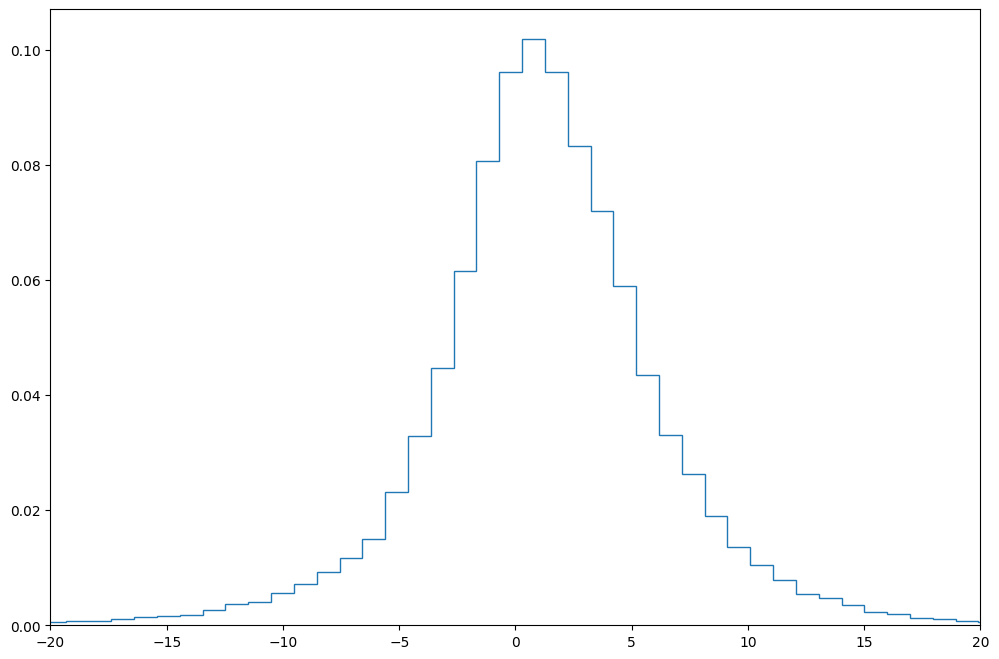

In [43]:
bins = plot_coord_distrib(227)

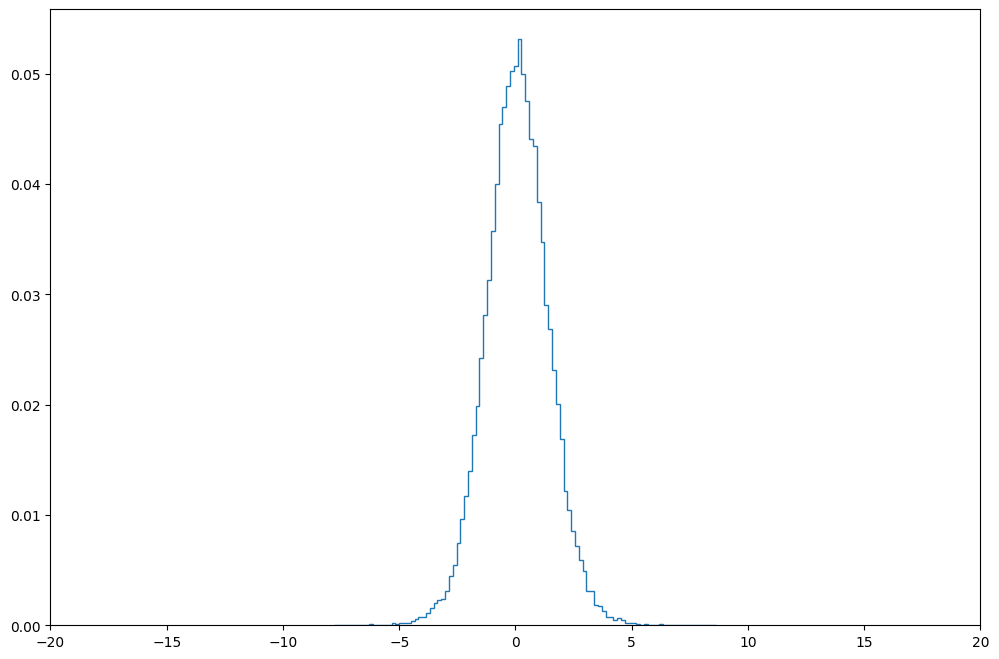

In [33]:
bins = plot_coord_distrib(227)

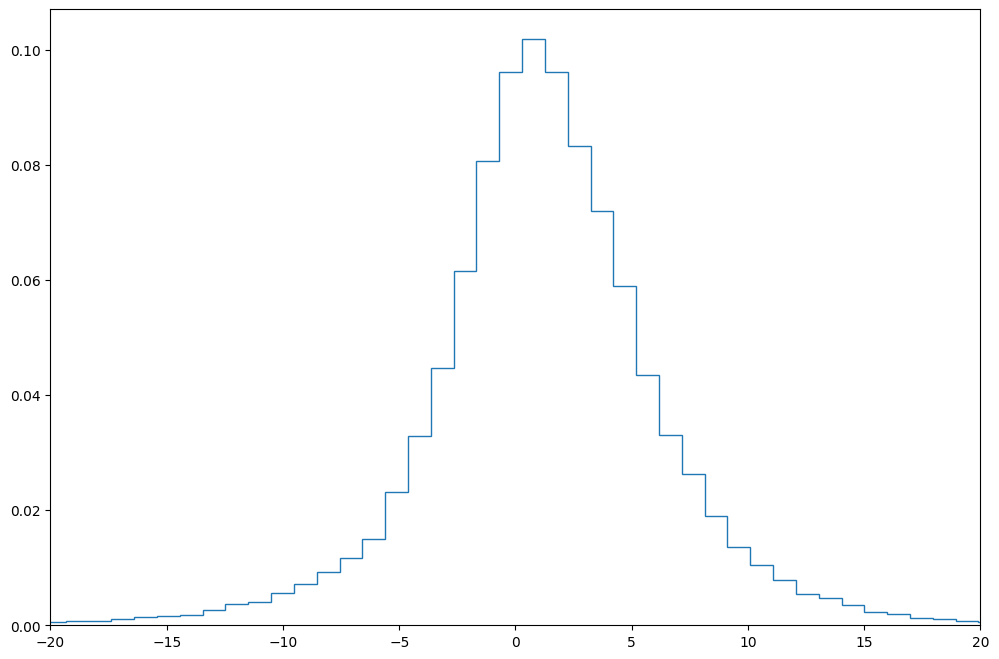

In [42]:
bins = plot_coord_distrib(227)

In [21]:
def plot_coord_distrib(coord_idx: int):
    obs = latent_ode_encs.reshape(-1, 768)[:, coord_idx]
    plt.figure(figsize=(12, 8))
    counts, bins = np.histogram(obs, bins=100)
    plt.stairs(counts / obs.shape[0], bins)
    plt.xlim(-20, 20)
    return bins

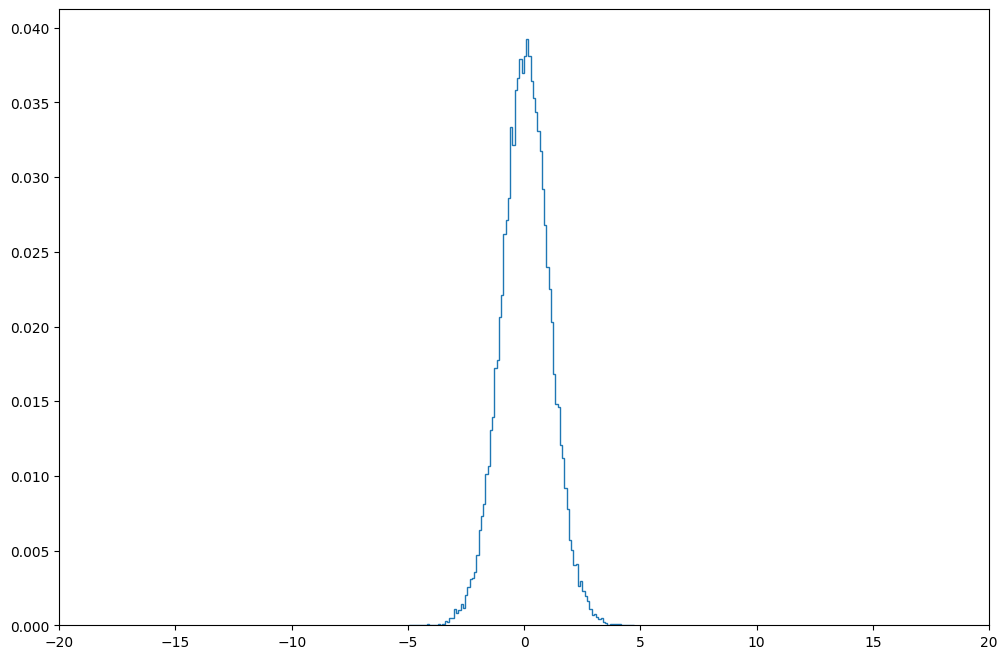

In [22]:
bins = plot_coord_distrib(227)

In [23]:
from scipy.stats import norm
probs = norm.pdf(bins, 0, 1)

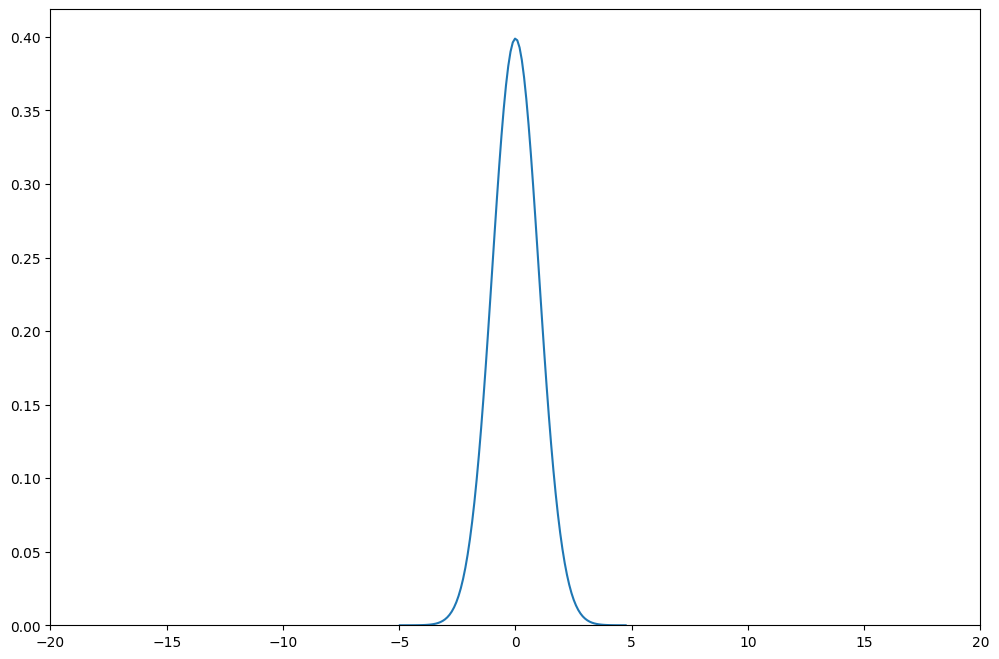

In [24]:

plt.figure(figsize=(12, 8))
plt.plot(bins, probs)
plt.ylim(0)
plt.xlim(-20, 20)
plt.show()